<a href="https://colab.research.google.com/github/VXLAKS/DZ1/blob/main/student_perfomance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas matplotlib seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Загрузка данных
# Определяем типы данных для оптимизации памяти
train_dtype = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

# Загрузка первых 1 млн строк train.csv
train_df = pd.read_csv('train.csv', nrows=1000000, dtype=train_dtype)

# Загрузка других файлов
questions_df = pd.read_csv('questions.csv', dtype={
    'question_id': 'int16',
    'bundle_id': 'int16',
    'correct_answer': 'int8',
    'part': 'int8'
})
lectures_df = pd.read_csv('lectures.csv', dtype={
    'lecture_id': 'int16',
    'part': 'int8'
})

# 2. Первичный осмотр данных
print("Train DataFrame:")
print(train_df.head())
print(train_df.info())

print("\nQuestions DataFrame:")
print(questions_df.head())
print(questions_df.info())

print("\nLectures DataFrame:")
print(lectures_df.head())
print(lectures_df.info())

# Проверка пропусков
print("\nПропуски в train_df:")
print(train_df.isnull().sum())

print("\nПропуски в questions_df:")
print(questions_df.isnull().sum())

print("\nПропуски в lectures_df:")
print(lectures_df.isnull().sum())

# 3. Объединение данных
# Слияние train_df с questions_df и lectures_df
merged_df = train_df.merge(
    questions_df,
    how='left',
    left_on='content_id',
    right_on='question_id'
).merge(
    lectures_df,
    how='left',
    left_on='content_id',
    right_on='lecture_id'
)

# Проверка структуры объединенного DataFrame
print("\nОбъединенный DataFrame:")
print(merged_df.info())
print(merged_df.head())

Train DataFrame:
   row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0       0          0      115        5692                0                  1   
1       1      56943      115        5716                0                  2   
2       2     118363      115         128                0                  0   
3       3     131167      115        7860                0                  3   
4       4     137965      115        7922                0                  4   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   

   prior_question_had_explanation  
0                            <NA>  
1                    

In [ ]:
# 4. Анализ характеристик, влияющих на успеваемость

# 4.1 Процент правильно отвеченных вопросов
total_questions = len(train_df[train_df['content_type_id'] == 0])  # Только вопросы
correct_answers = train_df[(train_df['answered_correctly'] == 1) & (train_df['content_type_id'] == 0)]
success_rate = len(correct_answers) / total_questions * 100
print(f"Процент правильно отвеченных вопросов: {success_rate:.2f}%")

# 4.2 Влияние времени на правильность ответа
time_correct = train_df[train_df['answered_correctly'] == 1]['prior_question_elapsed_time']
time_incorrect = train_df[train_df['answered_correctly'] == 0]['prior_question_elapsed_time']

# 4.3 Влияние объяснений на правильность ответа
explanation_correct = train_df[(train_df['prior_question_had_explanation'] == True) & (train_df['answered_correctly'] == 1)]
explanation_incorrect = train_df[(train_df['prior_question_had_explanation'] == True) & (train_df['answered_correctly'] == 0)]
no_explanation_correct = train_df[(train_df['prior_question_had_explanation'] == False) & (train_df['answered_correctly'] == 1)]

# 4.4 Роль лекций в обучении
lectures_count = len(train_df[train_df['content_type_id'] == 1])
questions_after_lectures = train_df[(train_df['content_type_id'] == 0) & (train_df['task_container_id'].shift(1) == train_df['task_container_id'])]

# 4.5 Анализ тегов вопросов
tags_df = questions_df['tags'].str.get_dummies(sep=' ').mul(train_df['answered_correctly'], axis=0).mean()

# 4.6 Категории лекций
lectures_part_df = lectures_df.groupby('part')['lecture_id'].count()

# 4.7 Попытки решения
attempts = train_df.groupby(['user_id', 'task_container_id'])['answered_correctly'].mean()


Процент правильно отвеченных вопросов: 65.04%


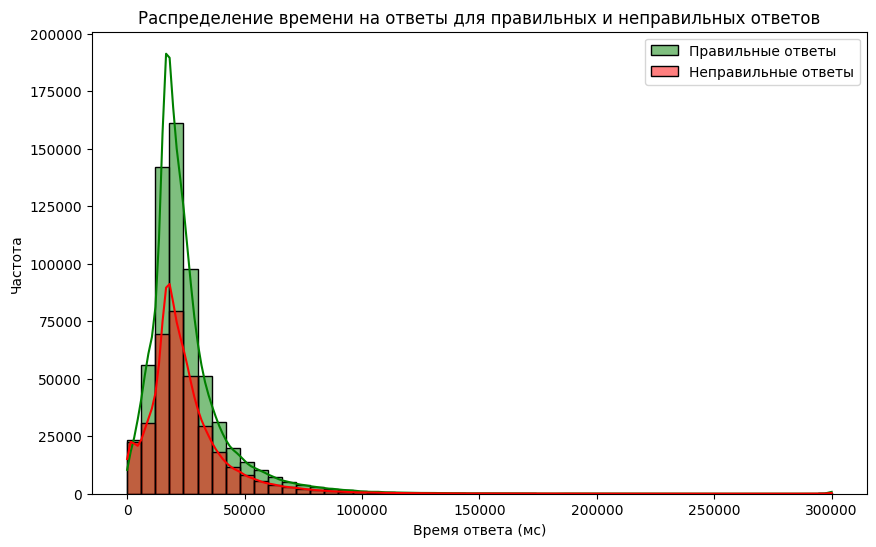

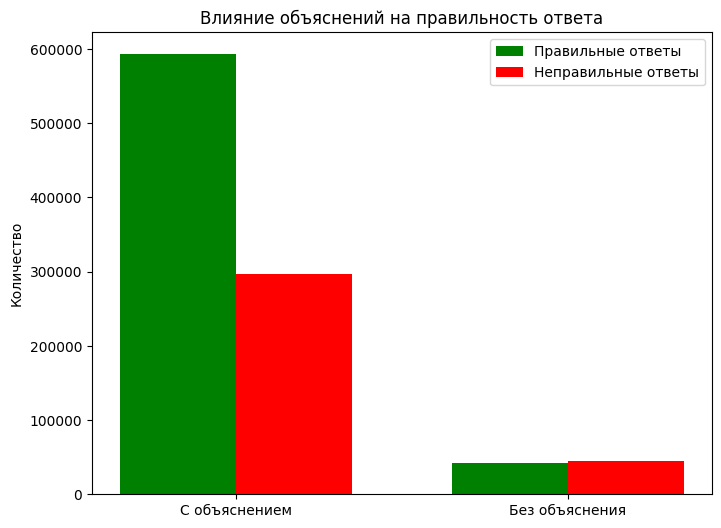

C:\Users\Vxlaks\AppData\Local\Temp\ipykernel_9624\1077514721.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags_df.index, y=tags_df.values, palette='viridis')


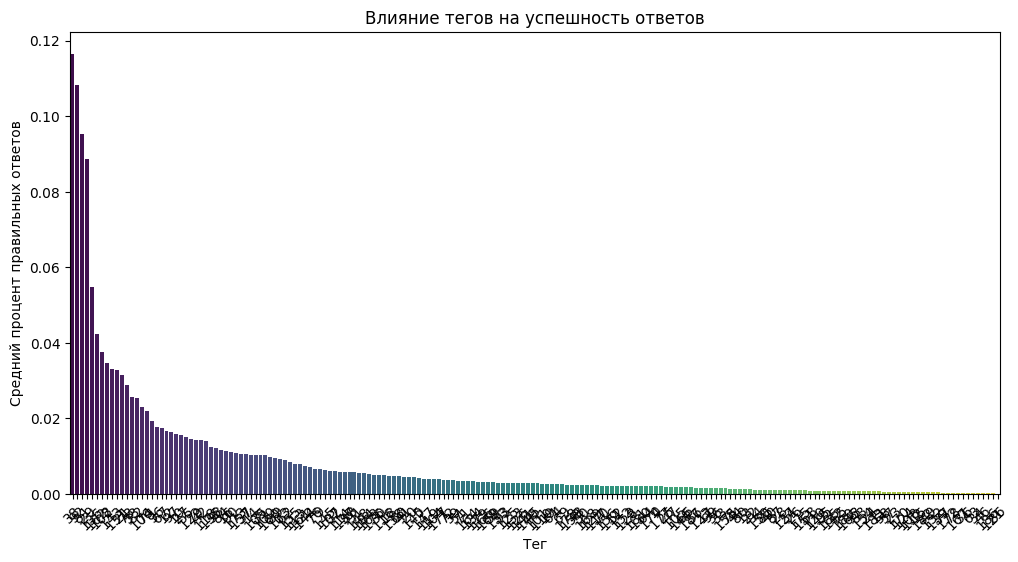

C:\Users\Vxlaks\AppData\Local\Temp\ipykernel_9624\1077514721.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lectures_part_df.index, y=lectures_part_df.values, palette='coolwarm')


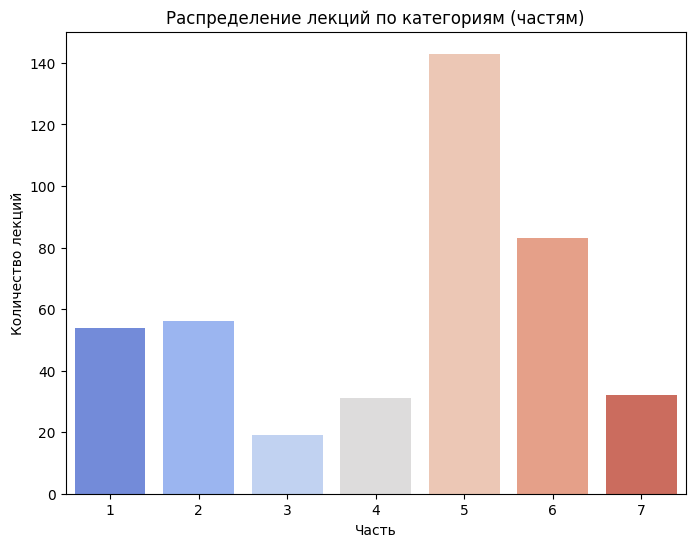

In [ ]:
# 5. Визуализация данных

# 5.1 Распределение времени ответа на вопросы для правильных и неправильных ответов
time_correct = train_df[train_df['answered_correctly'] == 1]['prior_question_elapsed_time']
time_incorrect = train_df[train_df['answered_correctly'] == 0]['prior_question_elapsed_time']

plt.figure(figsize=(10, 6))
sns.histplot(time_correct, bins=50, kde=True, color='green', label='Правильные ответы')
sns.histplot(time_incorrect, bins=50, kde=True, color='red', label='Неправильные ответы')
plt.title('Распределение времени на ответы для правильных и неправильных ответов')
plt.xlabel('Время ответа (мс)')
plt.ylabel('Частота')
plt.legend()
plt.show()

# 5.2 Влияние объяснений на правильность ответа
explanation_correct = train_df[(train_df['prior_question_had_explanation'] == True) & (train_df['answered_correctly'] == 1)]
explanation_incorrect = train_df[(train_df['prior_question_had_explanation'] == True) & (train_df['answered_correctly'] == 0)]
no_explanation_correct = train_df[(train_df['prior_question_had_explanation'] == False) & (train_df['answered_correctly'] == 1)]
no_explanation_incorrect = train_df[(train_df['prior_question_had_explanation'] == False) & (train_df['answered_correctly'] == 0)]

labels = ['С объяснением', 'Без объяснения']
correct_counts = [len(explanation_correct), len(no_explanation_correct)]
incorrect_counts = [len(explanation_incorrect), len(no_explanation_incorrect)]

plt.figure(figsize=(8, 6))
bar_width = 0.35
x = range(len(labels))
plt.bar(x, correct_counts, bar_width, label='Правильные ответы', color='green')
plt.bar([p + bar_width for p in x], incorrect_counts, bar_width, label='Неправильные ответы', color='red')
plt.xticks([p + bar_width / 2 for p in x], labels)
plt.title('Влияние объяснений на правильность ответа')
plt.ylabel('Количество')
plt.legend()
plt.show()

# 5.3 Связь тегов с успеваемостью
tags_df = questions_df['tags'].str.get_dummies(sep=' ').mul(train_df['answered_correctly'], axis=0).mean()
tags_df.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=tags_df.index, y=tags_df.values, palette='viridis')
plt.title('Влияние тегов на успешность ответов')
plt.xlabel('Тег')
plt.ylabel('Средний процент правильных ответов')
plt.xticks(rotation=45)
plt.show()

# 5.4 Анализ категорий лекций
lectures_part_df = lectures_df.groupby('part')['lecture_id'].count()

plt.figure(figsize=(8, 6))
sns.barplot(x=lectures_part_df.index, y=lectures_part_df.values, palette='coolwarm')
plt.title('Распределение лекций по категориям (частям)')
plt.xlabel('Часть')
plt.ylabel('Количество лекций')
plt.show()
